<a href="https://colab.research.google.com/github/sheikmohdimran/Deep_Learning_with_Pytorch/blob/main/02_Computer_Vision/02_Dog_breed_Classification_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog breed classification
The dataset consists of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal is to create a classifier capable of determining a dog's breed from a photo.

Reference: https://www.kaggle.com/c/dog-breed-identification/data

In [1]:
!pip install fastai==2.4.1 -qqq
!pip install wandb -qqq
!pip install --upgrade --force-reinstall --no-deps kaggle -qqq
!pip install torchsnooper -qqq
!pip install albumentations --upgrade -qqq

     |████████████████████████████████| 188 kB 8.2 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 1.7 MB 6.7 MB/s 
     |████████████████████████████████| 170 kB 77.1 MB/s 
     |████████████████████████████████| 97 kB 9.4 MB/s 
     |████████████████████████████████| 133 kB 69.9 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 58 kB 4.5 MB/s 
     |████████████████████████████████| 98 kB 5.5 MB/s 
     |████████████████████████████████| 37.1 MB 66 kB/s 


In [3]:
#@title Download Dataset
!echo '{"username":"imrandude","key":"<kaggle_key>"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c dog-breed-identification

 99% 686M/691M [00:07<00:00, 117MB/s]
100% 691M/691M [00:07<00:00, 98.2MB/s]


In [4]:
!unzip -q dog-breed-identification.zip

## Prepare Dataframes for Datasets

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from pathlib import Path
import pandas as pd
import numpy as np

In [31]:
labels = pd.read_csv('./labels.csv')
labels['id']=labels['id']+'.jpg'
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [36]:
train_data_dir = Path('/content/train')

files = train_data_dir.rglob('*.jpg')
input=pd.DataFrame(files,columns =['file_path'])
input['file_path']=input['file_path'].astype(str)
df_train=input['file_path'].str.split('/',expand=True)
train=input.join(df_train)[['file_path',3]]
train.columns=('file_path','id')
train=train.merge(labels, on="id")
train.head()

,file_path,id,breed
0,/content/train/07ebe25829d387cef30160285d50e232.jpg,07ebe25829d387cef30160285d50e232.jpg,labrador_retriever
1,/content/train/a1eb2b04c498844ec38bf5ac5b6184e7.jpg,a1eb2b04c498844ec38bf5ac5b6184e7.jpg,australian_terrier
2,/content/train/8daabe9ded307c802b5f84492bc14d69.jpg,8daabe9ded307c802b5f84492bc14d69.jpg,maltese_dog
3,/content/train/2f2a1a2a5079ab84baadbbbde66d98ef.jpg,2f2a1a2a5079ab84baadbbbde66d98ef.jpg,basenji
4,/content/train/07b5288a0bb8b9cf1a42d281a9451e51.jpg,07b5288a0bb8b9cf1a42d281a9451e51.jpg,irish_water_spaniel


In [68]:
le = preprocessing.LabelEncoder()
le.fit(train['breed'])
train['label_enc']=le.transform(train['breed'])
train.head()

,file_path,id,breed,label_enc
0,/content/train/07ebe25829d387cef30160285d50e232.jpg,07ebe25829d387cef30160285d50e232.jpg,labrador_retriever,67
1,/content/train/a1eb2b04c498844ec38bf5ac5b6184e7.jpg,a1eb2b04c498844ec38bf5ac5b6184e7.jpg,australian_terrier,6
2,/content/train/8daabe9ded307c802b5f84492bc14d69.jpg,8daabe9ded307c802b5f84492bc14d69.jpg,maltese_dog,73
3,/content/train/2f2a1a2a5079ab84baadbbbde66d98ef.jpg,2f2a1a2a5079ab84baadbbbde66d98ef.jpg,basenji,7
4,/content/train/07b5288a0bb8b9cf1a42d281a9451e51.jpg,07b5288a0bb8b9cf1a42d281a9451e51.jpg,irish_water_spaniel,58


In [69]:
no_of_classes= train['label_enc'].max()+1
target_strings = le.inverse_transform(np.arange(no_of_classes))
target_strings

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [39]:
train_df,valid_df= train_test_split(train, test_size=0.20, random_state=42, stratify=train['label_enc'])
train_df.reset_index(inplace = True)
valid_df.reset_index(inplace = True)

## Create Pytorch Dataset with transformations


In [40]:
import torch
from torch import nn
from torch import sigmoid
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from copy import deepcopy

from fastai.vision.all import *
import torchsnooper

In [41]:
class CustomImageDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.img_labels = data_frame['label_enc']
        self.img_path = data_frame['file_path']
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = cv2.imread(self.img_path.iloc[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx].astype(np.long)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [42]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.HorizontalFlip(),
        A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [43]:
train_data = CustomImageDataset(data_frame=train_df,transform=train_transform)
valid_data = CustomImageDataset(data_frame=valid_df,transform=val_transform)

trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
validloader = DataLoader(valid_data, batch_size=256, shuffle=False)

In [44]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

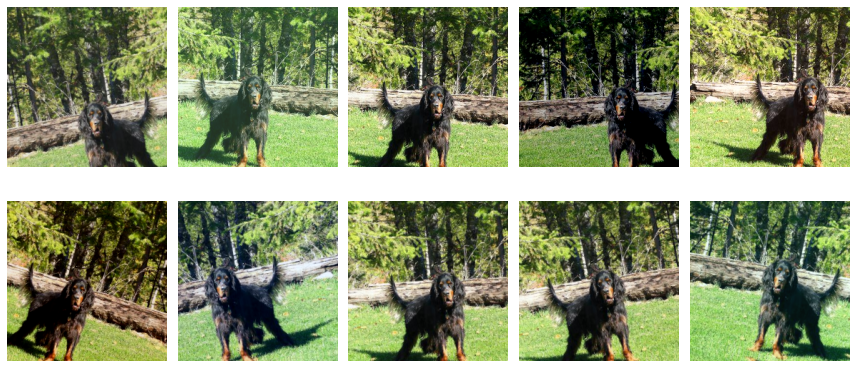

In [45]:
random.seed(42)
visualize_augmentations(train_data)

## Create model

In [57]:
def create_model(flattened_dim = 1024): 
  return nn.Sequential(
        # Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
        nn.Conv2d(3, 32, 5, padding = 'same'),
        nn.ReLU(),
        
        # Add a Max Pooling layer of size 2X2
        nn.MaxPool2d(3),
        nn.Dropout(p=0.2), 
        
        # Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
        nn.Conv2d(32, 64, 4, padding = 'same'),
        nn.ReLU(),
        
        # Add a Max Pooling layer again
        nn.MaxPool2d(2),
        nn.Dropout(p=0.2),
        
        # Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
        nn.Conv2d(64, 128, 3, padding = 'same'),
        nn.ReLU(),
        
        # Add a Max Pooling layer again
        nn.MaxPool2d(2),
        nn.Dropout(p=0.2),

        # Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
        nn.Conv2d(128, 128, 2, padding = 'same'),
        nn.ReLU(),
        
        # Add a Max Pooling layer again
        nn.MaxPool2d(2),
        nn.Dropout(p=0.2),
        
        # Flattening the layer before fully connected layers
        nn.Flatten(),
        
        # Adding a fully connected layer with 512 neurons
        nn.Linear(flattened_dim, 512), 
        nn.ReLU(),
        
        # Adding dropout with probability 0.5
        nn.Dropout(p=0.2),

        # The final output layer with 5 neuron to predict the categorical classifcation
        nn.Linear(512, 120),
    )

In [59]:
with torchsnooper.snoop():
  model = create_model(10368)
  model(torch.zeros(1,3,224,224))

Source path:... <ipython-input-59-17d952b5267b>
New var:....... __name__ = '__main__'
New var:....... __doc__ = 'input[\'a\']=input[\'a\'].astype(str)\ndf_train...train=train.merge(labels, on="id")\ntrain.head()'
New var:....... __package__ = None
New var:....... __loader__ = None
New var:....... __spec__ = None
New var:....... __builtin__ = <module 'builtins' (built-in)>
New var:....... __builtins__ = <module 'builtins' (built-in)>
New var:....... _ih = ['', 'from sklearn.model_selection import train_...model(10368)\n  model(torch.zeros(1,3,224,224))']
New var:....... _oh = {2:                                      id     ...object>, 50: tensor<(3, 224, 224), float32, cpu>}
New var:....... _dh = ['/content']
New var:....... _sh = <module 'IPython.core.shadowns' from '/usr/local...ython3.7/dist-packages/IPython/core/shadowns.py'>
New var:....... In = ['', 'from sklearn.model_selection import train_...model(10368)\n  model(torch.zeros(1,3,224,224))']
New var:....... Out = {2:            

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [60]:
model = create_model(10368)
model = model.to(device)

data = DataLoaders(trainloader, validloader)
learn = Learner(data, 
                model, 
                loss_func=CrossEntropyLossFlat(), 
                opt_func=Adam, 
                metrics=accuracy)

In [61]:
learn.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,4.786994,4.782236,0.012225,01:13
1,4.780973,4.777287,0.012225,01:10
2,4.783773,4.775273,0.012225,01:11
3,4.760801,4.728306,0.017604,01:10
4,4.676659,4.631178,0.023472,01:11


## Transfer Learning

In [74]:
tl_model=models.resnet18(pretrained=True)

In [75]:
for name, module in tl_model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [76]:
for name, module in tl_model.named_children():
  for param in module.parameters():
      param.requires_grad = False

In [77]:
tl_model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [78]:
print(no_of_classes)

120


In [79]:
tl_model.fc = nn.Sequential(OrderedDict([
          ('lin1', nn.Linear(in_features=512, out_features=256)),
          ('relu1', nn.ReLU()),
          ('lin2', nn.Linear(in_features=256, out_features=no_of_classes))
        ]))

In [80]:
print(device)

cuda


In [81]:
tl_model = tl_model.to(device)
data = DataLoaders(trainloader, validloader)
learn = Learner(data, 
                tl_model, 
                loss_func=nn.CrossEntropyLoss(), 
                opt_func=Adam, 
                metrics=accuracy)

In [82]:
learn.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.869313,1.259410,0.650367,01:05
1,1.246132,0.958904,0.688020,01:04
2,1.112162,0.850987,0.727628,01:05
3,1.022831,0.846573,0.733496,01:05
4,0.919834,0.841594,0.734474,01:05


## Additional Reading
* https://github.com/albanie/convnet-burden/blob/master/reports/resnet18.md
* https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/34